# Import module

In [1]:
import sys
sys.path.append('/home/glemieux/Repos/fates/tools/luh2/')

In [2]:
from luh2mod import ImportData, SetMaskLUH2, SetMaskSurfData, RegridConservative, CorrectStateSum, AttributeUpdateLUH2

# Import and Prep Data

In [3]:
state_fn = "/home/glemieux/Data/luh2/states.nc"
static_fn = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
surf_fn = "/home/glemieux/Data/luh2/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc"
transitions_fn = "/home/glemieux/Data/luh2/transitions.nc"
management_fn = "/home/glemieux/Data/luh2/management.nc"

## Modify the data to use cftime compatible format

In [4]:
AttributeUpdateLUH2(state_fn)

Generated modified output file: /home/glemieux/Data/luh2/states_modified.nc



'/home/glemieux/Data/luh2/states_modified.nc'

## Import modified data

In [5]:
statemod_fn = "/home/glemieux/Data/luh2/states_modified.nc"

In [6]:
ds_luh2 = ImportData(statemod_fn)
ds_regrid_target = ImportData(surf_fn)
ds_luh2_static = ImportData(static_fn)

Input file dataset opened: /home/glemieux/Data/luh2/states_modified.nc
LUH2
PrepDataset: LUH2
LUH2 dataset lat/lon boundary variables formatted and added as new variable for xESMF
data set updated for xESMF

Input file dataset opened: /home/glemieux/Data/luh2/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc
Surface
PrepDataset: SurfData
Surface dataset dimensions renamed for xESMF
data set updated for xESMF

Input file dataset opened: /home/glemieux/Data/luh2/staticData_quarterdeg.nc


## Calculate land fraction and mask to normalize against

In [7]:
ds_luh2_static["landfrac"] = 1 - ds_luh2_static.icwtr

In [8]:
ds_luh2 = SetMaskLUH2(ds_luh2, ds_luh2_static)
ds_luh2_static = SetMaskLUH2(ds_luh2_static,ds_luh2_static)
ds_regrid_target = SetMaskSurfData(ds_regrid_target)

# Regrid

In [10]:
from luh2mod import GenerateRegridder

In [32]:
ds_regrid = ds_luh2['secmb'].copy(deep=True)

In [26]:
ds_regrid = ds_regrid.to_dataset()

In [18]:
regridder = GenerateRegridder(ds_luh2,ds_regrid_target,'regridder.nc',False)


Defining regridder, method:  conservative


/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


regridder saved to file:  regridder.nc


In [34]:
ds_regrid = regridder(ds_regrid)

RuntimeError: NetCDF: HDF error

In [17]:
regrid_luh2, regridder_luh2 = RegridConservative(ds_luh2, ds_regrid_target,'regridder.nc',False)


Defining regridder, method:  conservative


/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


regridder saved to file:  regridder.nc

Regridding
skipping variable 1/20: time
skipping variable 2/20: lat
skipping variable 3/20: lon
regridding variable 4/20: primf
regridding variable 5/20: primn
regridding variable 6/20: secdf
regridding variable 7/20: secdn
regridding variable 8/20: urban
regridding variable 9/20: c3ann
regridding variable 10/20: c4ann
regridding variable 11/20: c3per
regridding variable 12/20: c4per
regridding variable 13/20: c3nfx
regridding variable 14/20: pastr
regridding variable 15/20: range


RuntimeError: NetCDF: HDF error

In [9]:
regrid_land_fraction = regridder_luh2(ds_luh2_static)

In [10]:
# Save off the regrid
regrid_luh2_save = regrid_luh2

Normalize by the land fraction

In [11]:
regrid_luh2 = regrid_luh2_save
regrid_luh2 = regrid_luh2 / regrid_land_fraction.landfrac

# Sum the states and correct those states that don't sum to unity

In [12]:
# Sum the states across the renaming variables including 'urban'
state_sum = regrid_luh2.drop_vars({"secmb","secma"}).to_array().sum(dim="variable") 
# state_sum = regrid_luh2.to_array().sum(dim="variable") 
state_sum = state_sum.where(state_sum != 0)  # Convert 0 to nan

In [13]:
import matplotlib.pyplot as plt
# import xarray as xr
# import numpy as np
# import xesmf as xe

### Check the state sum for non-unity values to see where we have to correct

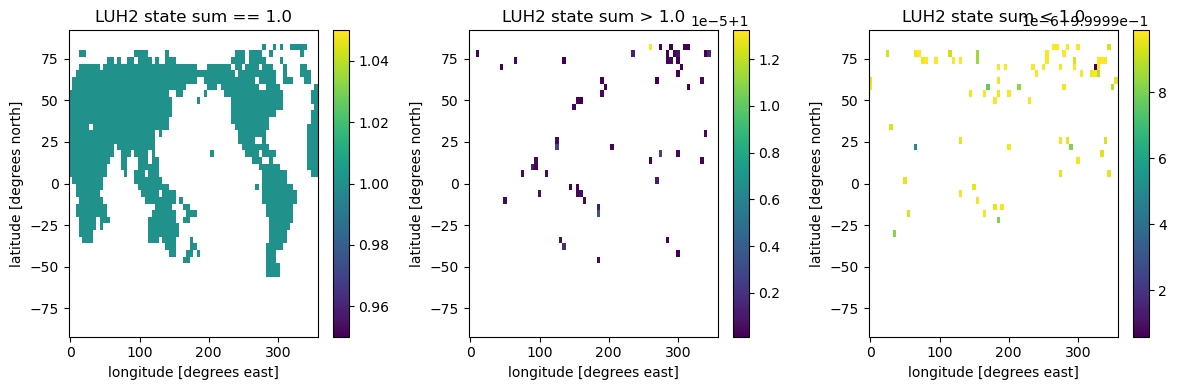

In [14]:
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
state_sum.where(state_sum.mean(dim='time') == 1.0).mean(dim='time').plot(ax=axs[0])
axs[0].set_title('LUH2 state sum == 1.0')
state_sum.where(state_sum.mean(dim='time') > 1.0).mean(dim='time').plot(ax=axs[1])
axs[1].set_title('LUH2 state sum > 1.0')
state_sum.where(state_sum.mean(dim='time') < 1.0).mean(dim='time').plot(ax=axs[2])
axs[2].set_title('LUH2 state sum < 1.0')
fig.tight_layout()
# fig.suptitle('time = 0850-01-01')

### Now correct and check the sum again

In [15]:
# Scale the variables against values
# regrid_luh2 = regrid_luh2 / state_sum

In [16]:
regrid_luh2 = CorrectStateSum(regrid_luh2)

In [17]:
# Sum the states across the renaming variables including 'urban'
state_sum = regrid_luh2.drop_vars({"secmb","secma"}).to_array().sum(dim="variable") 
state_sum = state_sum.where(state_sum != 0)  # Convert 0 to nan

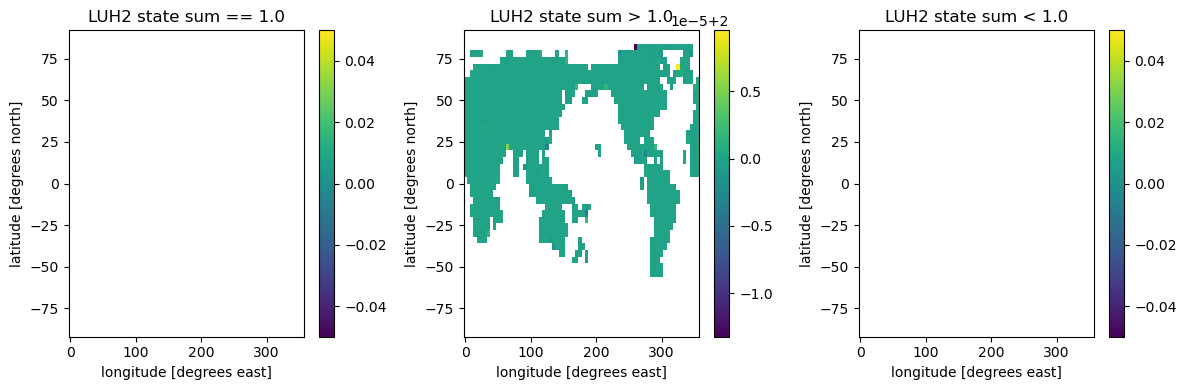

In [18]:
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
state_sum.where(state_sum.mean(dim='time') == 1.0).mean(dim='time').plot(ax=axs[0])
axs[0].set_title('LUH2 state sum == 1.0')
state_sum.where(state_sum.mean(dim='time') > 1.0).mean(dim='time').plot(ax=axs[1])
axs[1].set_title('LUH2 state sum > 1.0')
state_sum.where(state_sum.mean(dim='time') < 1.0).mean(dim='time').plot(ax=axs[2])
axs[2].set_title('LUH2 state sum < 1.0')
fig.tight_layout()
# fig.suptitle('time = 0850-01-01')

# Correct the dimension names

In [23]:
'lat' in list(regrid_luh2.dims)

True

In [24]:
regrid_luh2["LONGXY"] = ds_regrid_target["LONGXY"]
regrid_luh2["LATIXY"] = ds_regrid_target["LATIXY"]

In [25]:
regrid_luh2.rename_dims({'lat':'lsmlat','lon':'lsmlon'})

<xarray.Dataset>
Dimensions:  (time: 1166, lsmlon: 72, lsmlat: 46)
Coordinates:
  * time     (time) object 0850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lsmlon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lsmlat) float64 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
Dimensions without coordinates: lsmlon, lsmlat
Data variables: (12/17)
    primf    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    primn    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    secdf    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    secdn    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    urban    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    c3ann    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    ...       ...
    range    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    secmb    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    secma    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    stscf    (time, lsmlat, lsmlon) float32 nan nan nan nan ... nan nan nan nan
    LONGXY   (lsmlat, lsmlon) float64 ...
    LATIXY   (lsmlat, lsmlon) float64 ...

In [47]:
regrid_luh2["YEAR"] = regrid_luh2.time

# Test import regrid

In [26]:
regrid_file = "regridder.nc"

In [30]:
import xesmf as xe
import xarray as xr

In [28]:
%%time
regridder_reuse = xe.Regridder(ds_luh2,ds_regrid_target,'conservative',weights=regrid_file)

CPU times: user 4.75 s, sys: 60.3 ms, total: 4.81 s
Wall time: 4.8 s


/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [29]:
regrid_luh2_test, regridder_luh2_test = RegridConservative(ds_luh2, ds_regrid_target,'regridder.nc',True)


Defining regridder, method:  conservative


/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')



Regridding
skipping variable 1/20: time
skipping variable 2/20: lat
skipping variable 3/20: lon
regridding variable 4/20: primf
regridding variable 5/20: primn
regridding variable 6/20: secdf
regridding variable 7/20: secdn
regridding variable 8/20: urban
regridding variable 9/20: c3ann
regridding variable 10/20: c4ann
regridding variable 11/20: c3per
regridding variable 12/20: c4per
regridding variable 13/20: c3nfx
regridding variable 14/20: pastr
regridding variable 15/20: range
regridding variable 16/20: secmb
regridding variable 17/20: secma
skipping variable 18/20: lat_b
skipping variable 19/20: lon_b


In [32]:
xr.testing.assert_identical(regrid_luh2_save,regrid_luh2_test)

# Test merging

In [33]:
ds_manage = ImportData(management_fn)

Input file dataset opened: /home/glemieux/Data/luh2/management_modified.nc
Unrecognize data set


In [44]:
dsvars = list(ds_manage.variables)
any('irrig' in name for name in dsvars)

True

In [47]:
ds_manage = SetMaskLUH2(ds_manage,ds_luh2_static)

In [49]:
ds_manage

<xarray.Dataset>
Dimensions:      (time: 1166, lat: 720, lon: 1440, bounds: 2)
Coordinates:
  * time         (time) object 0850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat          (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon          (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds
Data variables: (12/24)
    fertl_c3ann  (time, lat, lon) float32 ...
    irrig_c3ann  (time, lat, lon) float32 ...
    crpbf_c3ann  (time, lat, lon) float32 ...
    fertl_c4ann  (time, lat, lon) float32 ...
    irrig_c4ann  (time, lat, lon) float32 ...
    crpbf_c4ann  (time, lat, lon) float32 ...
    ...           ...
    rndwd        (time, lat, lon) float32 ...
    fulwd        (time, lat, lon) float32 ...
    combf        (time, lat, lon) float32 ...
    lat_bounds   (lat, bounds) float64 ...
    lon_bounds   (lon, bounds) float64 ...
    mask         (lat, lon) bool False False False False ... False False False
Attributes: (12/19)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011
    history:           Mon Mar 20 14:52:40 2023: /home/glemieux/local/conda/m...
    NCO:               netCDF Operators version 5.1.3 (Homepage = http://nco....

In [48]:
regrid_manage, regridder_manage = RegridConservative(ds_manage, ds_regrid_target,'regridder.nc',True)


Defining regridder, method:  conservative
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/frontend.py", line 69, in _get_lon_lat_bounds
    lon_bnds = ds.cf.get_bounds('longitude')
  File "/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/cf_xarray/accessor.py", line 2256, in get_bounds
    raise KeyError(f"No results found for {key!r}.")
KeyError: "No results found for 'longitude'."

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_337905/1677535313.py", line 1, in <module>
    regrid_manage, regridder_manage = RegridConservative(ds_manage, ds_regrid_target,'regridder.nc',True)
  File "/home/glemieux/Repos/fates/tools/luh2mod.py"